In [37]:
import tensorflow as tf
import os
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt

In [38]:
gpus = tf.config.experimental.list_physical_devices('CPU')

In [39]:
# limiting the usage of GPU by tensorflow, this will prevent OOM (Out Of Memory) error
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  # won't let tensorflow use all memory
  tf.config.experimental.set_memory_growth(gpu, True)

In [40]:
data_dir = 'data'    # this variable holds the path of the data

In [41]:
image_exts = ['jpg', 'jpeg', 'png', 'gif', 'bmp']  # extensions of images that will used

In [42]:
# removing invalid images
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            os.remove(image_path)

In [43]:
import numpy as np
from matplotlib import pyplot as plt

In [44]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 25778 files belonging to 2 classes.


In [45]:
data_iterator = data.as_numpy_iterator()

In [46]:
batch = data_iterator.next()

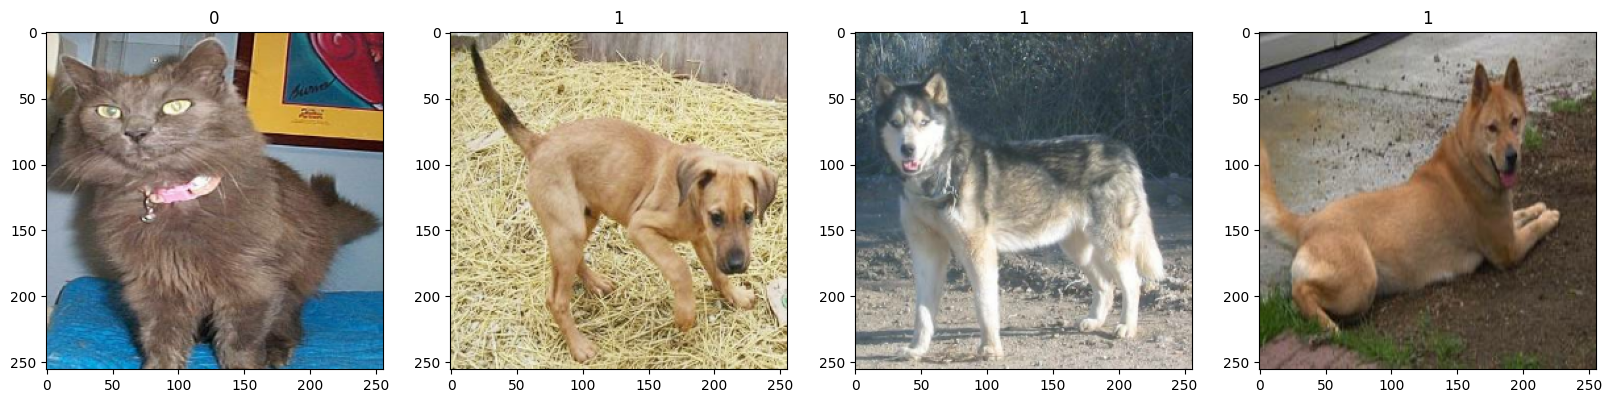

In [47]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [48]:
# data = data.map(lambda x,y: (x/255, y))
def scale_x(x, y):
    x_scaled = tf.clip_by_value(x / 255, 0.0, 1.0)
    return x_scaled, y

data = data.map(scale_x)

In [49]:
data.as_numpy_iterator().next()

(array([[[[0.90165347, 0.7977788 , 0.6294395 ],
          [0.88452524, 0.7873333 , 0.62637395],
          [0.86514246, 0.7789599 , 0.6260876 ],
          ...,
          [0.7561936 , 0.7758014 , 0.65031123],
          [0.7524663 , 0.77207416, 0.646584  ],
          [0.7500996 , 0.76970744, 0.6442172 ]],
 
         [[0.8927408 , 0.7853036 , 0.6279401 ],
          [0.891357  , 0.79418224, 0.63806134],
          [0.88838226, 0.80217665, 0.65717053],
          ...,
          [0.78572303, 0.8053309 , 0.6798407 ],
          [0.7830554 , 0.80266327, 0.6771731 ],
          [0.77155036, 0.7911582 , 0.665668  ]],
 
         [[0.8475128 , 0.7499081 , 0.5905581 ],
          [0.8633487 , 0.7698362 , 0.6179305 ],
          [0.8726499 , 0.7942415 , 0.6570389 ],
          ...,
          [0.7760557 , 0.79566354, 0.6701733 ],
          [0.7650728 , 0.78468066, 0.6591905 ],
          [0.74695647, 0.7665643 , 0.64107406]],
 
         ...,
 
         [[0.5968673 , 0.46853554, 0.25353095],
          [0.6    

In [50]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [51]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [53]:
model = Sequential()

In [54]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))  # Added Dropout for regularization
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [55]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [56]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 16)      

In [57]:
logdir='logs'

In [58]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [59]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
564/564 [==============================] - 727s 1s/step - loss: 0.6604 - accuracy: 0.6073 - val_loss: 0.6204 - val_accuracy: 0.6625
Epoch 2/10
564/564 [==============================] - 684s 1s/step - loss: 0.5596 - accuracy: 0.7154 - val_loss: 0.5791 - val_accuracy: 0.6858
Epoch 3/10
564/564 [==============================] - 672s 1s/step - loss: 0.4444 - accuracy: 0.7924 - val_loss: 0.5425 - val_accuracy: 0.7316
Epoch 4/10
564/564 [==============================] - 719s 1s/step - loss: 0.3101 - accuracy: 0.8656 - val_loss: 0.6389 - val_accuracy: 0.7273
Epoch 5/10
564/564 [==============================] - 760s 1s/step - loss: 0.1753 - accuracy: 0.9314 - val_loss: 0.8416 - val_accuracy: 0.7230
Epoch 6/10
564/564 [==============================] - 700s 1s/step - loss: 0.1027 - accuracy: 0.9640 - val_loss: 0.9870 - val_accuracy: 0.7176
Epoch 7/10
564/564 [==============================] - 900s 2s/step - loss: 0.0702 - accuracy: 0.9753 - val_loss: 1.0204 - val_accuracy: 0.7329

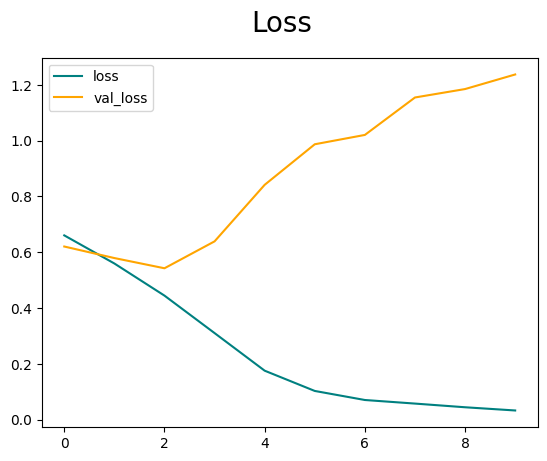

In [60]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

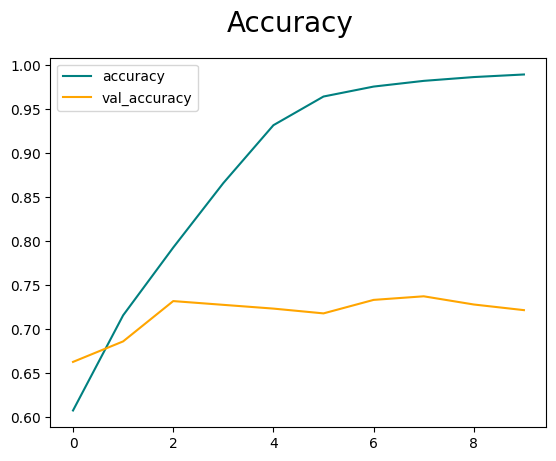

In [61]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [62]:
import cv2

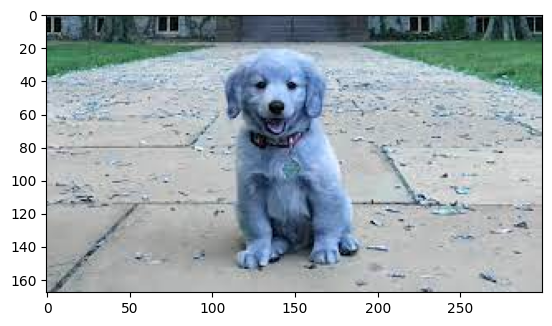

In [87]:
img = cv2.imread('data/dog_test.jpg')
plt.imshow(img)
plt.show()

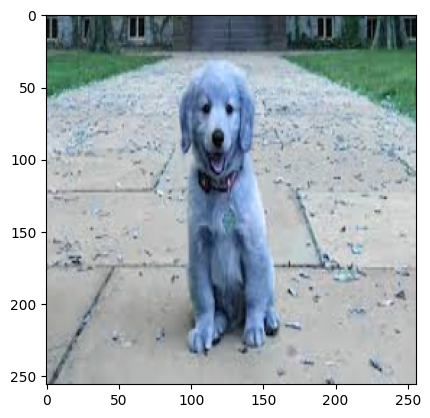

In [88]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [89]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 79ms/step


In [90]:
if yhat > 0.5: 
    print(f' Dog')
else:
    print(f'Cat')

 Dog


In [91]:
from tensorflow.keras.models import load_model

In [85]:
model.save(os.path.join('models','cat_dog_classifier.h5'))